<a href="https://colab.research.google.com/github/anushapalisetty/Intel-Image-Classification/blob/main/Densnet2_Model_Demo_Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np 
import cv2
import pandas as pd
import tensorflow as tf
import pandas as pd
import operator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.1)
# train_datagen = ImageDataGenerator(horizontal_flip=True,shear_range=0.2,  
#     zoom_range=0.2, validation_split=0.1)
"""train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.01,
      zoom_range=[0.1, 1.5],
      horizontal_flip=True,
      fill_mode='nearest',
      zca_whitening=True,
      brightness_range=[0.1, 2]
)"""


train_generator=train_datagen.flow_from_directory(
     '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training'
    
)

validation_generator=train_datagen.flow_from_directory(
      '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation'
    
)

#test_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/', 
    target_size=(150,150),
    batch_size=64,
    class_mode='sparse',
    seed=2209
) 

test1_datagen = ImageDataGenerator()
test1_generator = test1_datagen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/', 
    target_size=(150,150),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=2209
) 

Found 12667 images belonging to 6 classes.
Found 1406 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
def img_reshape(img):
  img=cv2.resize(img,(150,150))
  plt.imshow(img.reshape([150,150,3]))
  img = np.reshape(img,[1,150,150,3])
  return img

# **DenseNet121**

In [6]:
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np 
from keras.applications.densenet import DenseNet121
import keras


base_model1=DenseNet121(include_top=False, weights= 'imagenet',  input_shape=(150,150,3), pooling='avg')
base_model1.trainable = False

x = Dense(256, activation='relu')(base_model1.output)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_model1 = Model(base_model1.input, x) 
transfer_model1.compile(optimizer =keras.optimizers.SGD(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

29089792/29084464 [==============================] - 0s 0us/step


In [7]:
import tensorflow as tf
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
history2 = transfer_model1.fit_generator(
            train_generator,
            steps_per_epoch=int(12667 /64),
            epochs=120,
            validation_data=validation_generator,
            validation_steps=int(1406 /64),
            callbacks=[reduce],
            verbose=1)
transfer_model1.save('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_5.hd5')


reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#accuracy=model1.evaluate_generator(test_generator)
accuracy=transfer_model1.evaluate(test_generator,steps=len(test_generator)//32,callbacks=[reduce],verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])



df_cnn = pd.DataFrame(history2.history)      
# saving the dataframe  
df_cnn.to_csv('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_5_History.csv')  


classes1=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']
images=['georgia-state-university-1.png','forest.jpg','glacier.jpg','Pooru-Mountain.jpeg','Meg_Sea.jpg','Cali_street.jpg']
nrows=3
ncols=3
j=0
path='/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/'

plt.figure(figsize=[20,15])
for i, img in enumerate(images):
  labels={}
  sp=plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')
  image=mpimg.imread(path+img)
  plt.imshow(image)
  im_reshape=img_reshape(image)
  a=transfer_model1.predict(im_reshape).round(2)
  for j,label in enumerate(classes1):
      labels[classes1[j]]=a[0][j]
  sorted_d = sorted(labels.items(), key=operator.itemgetter(1),reverse=True)
  print(sorted_d)


  if i%3==0 and i>=3:
    j=j+1
  sp.title.set_text(classes1[i])

  
plt.show()


#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/120
197/197 [==============================] - 2323s 12s/step - loss: 2.7021 - accuracy: 0.1513 - val_loss: 1.9816 - val_accuracy: 0.1949
Epoch 2/120
197/197 [==============================] - 94s 480ms/step - loss: 2.1801 - accuracy: 0.2233 - val_loss: 1.6692 - val_accuracy: 0.3356
Epoch 3/120
197/197 [==============================] - 94s 480ms/step - loss: 1.9050 - accuracy: 0.2880 - val_loss: 1.4621 - val_accuracy: 0.4397
Epoch 4/120
197/197 [==============================] - 93s 473ms/step - loss: 1.7177 - accuracy: 0.3514 - val_loss: 1.2963 - val_accuracy: 0.5268
Epoch 5/120
197/197 [==============================] - 93s 472ms/step - loss: 1.5725 - accuracy: 0.3986 - val_loss: 1.1877 - val_accuracy: 0.6042
Epoch 6/120
197/197 [==============================] - 94s 477ms/step - loss: 1.4518 - accuracy: 0.4471 - val_loss: 1.0913 - val_accuracy: 0.6220
Epoch 7/120
197/197 [===========================

NameError: ignored

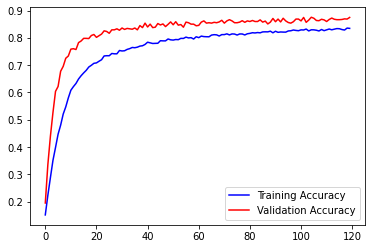

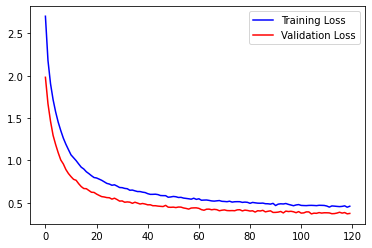

In [9]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()    

[('buildings', 0.57), ('street', 0.41), ('sea', 0.01), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0)]
[('buildings', 1.0), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0), ('sea', 0.0), ('street', 0.0)]
[('buildings', 1.0), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0), ('sea', 0.0), ('street', 0.0)]
[('buildings', 0.89), ('street', 0.11), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0), ('sea', 0.0)]
[('buildings', 1.0), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0), ('sea', 0.0), ('street', 0.0)]
[('buildings', 1.0), ('forest', 0.0), ('glacier', 0.0), ('mountain', 0.0), ('sea', 0.0), ('street', 0.0)]


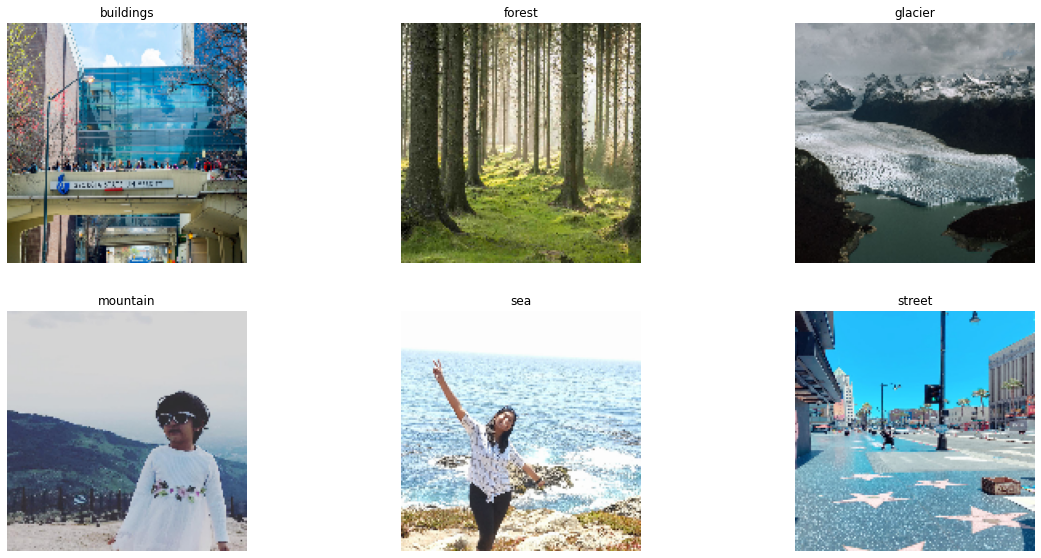

In [12]:
classes1=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']
images=['georgia-state-university-1.png','forest.jpg','glacier.jpg','Pooru-Mountain.jpeg','Meg_Sea.jpg','Cali_street.jpg']
nrows=3
ncols=3
j=0
path='/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/'

plt.figure(figsize=[20,15])
for i, img in enumerate(images):
  labels={}
  sp=plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')
  image=mpimg.imread(path+img)
  plt.imshow(image)
  im_reshape=img_reshape(image)
  a=transfer_model1.predict(im_reshape).round(2)
  for j,label in enumerate(classes1):
      labels[classes1[j]]=a[0][j]
  sorted_d = sorted(labels.items(), key=operator.itemgetter(1),reverse=True)
  print(sorted_d)


  if i%3==0 and i>=3:
    j=j+1
  sp.title.set_text(classes1[i])

  
plt.show()

In [ ]:
import tensorflow as tf
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#accuracy=model1.evaluate_generator(test_generator)
accuracy=transfer_model1.evaluate(test_generator,steps=len(test_generator)//32,callbacks=[reduce],verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [ ]:

import keras
#model1 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model.hd5')
model2 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_Dense_Git_4.hd5')

In [ ]:
import tensorflow as tf
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#accuracy=model1.evaluate_generator(test_generator)
accuracy=transfer_model1.evaluate(test_generator,steps=len(test_generator)//32,callbacks=[reduce],verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

In [ ]:
import os
path = '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/'
images = []

x = os.listdir("/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/")

for i in x:
    img = path + i
    images.append(img)
  

labels = {
    0 : "buildings" , 
    1 : "forest" , 
    2 : "glacier" , 
    3 : "mountain" , 
    4 : "sea" , 
    5 : "street"
}

from tensorflow.keras.preprocessing import image

outputs = []
ids = []
for i in images:
    img = image.load_img(i , target_size = (150,150))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis=0)
    c = transfer_model1.predict([img])
    pred_labels = np.argmax(c, axis = 1)
    la = labels[pred_labels[0]]
    
    outputs.append(la)
    ids.append(i)
import pandas as pd
data = pd.DataFrame({
    "Image" : ids , 
    "Label" : outputs
})

In [ ]:
data.Label.value_counts()

In [ ]:
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/georgia-state-university-1.png'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Cali_street.jpg'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Pooru-Mountain.jpeg'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/Meg_Sea.jpg'
#img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/glacier.jpg'
img= '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_pred/seg_pred/forest.jpg'

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img=cv2.imread(img)
print(img.shape)
img=cv2.resize(img,(150,150))
plt.imshow(img.reshape([150,150,3]))
img = np.reshape(img,[1,150,150,3])

In [ ]:
transfer_model1.predict(img).round(2)

In [ ]:
model2.predict(img).round(2)

In [ ]:
classes1=['buildings', 'forest' , 'glacier' , 'mountain', 'sea', 'street']